In [1]:
import glob
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
import natsort

In [2]:
# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# dt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
import pydotplus
from sklearn.tree import export_graphviz
from IPython.core.display import Image

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# SVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import PolynomialFeatures

# rf
from sklearn.ensemble import RandomForestClassifier

In [3]:
seed = 0
tf.random.set_seed(seed)

model_metrics = 'acc'    # acc, mse, mae (epoch마다 표시)
num_epochs = 10
num_batch = 100
num_split = 0.2

In [4]:
#새로운 feature 추가 데이터
new_H_path= 'D:/sensors journal/TT_H/train/new/txt'
new_H_files = glob.glob(os.path.join(new_H_path, "*.txt"))
new_H_files = natsort.natsorted(new_H_files)
print(new_H_files)
new_H_each_file = (pd.read_csv(f, header=None, sep = "\t") for f in new_H_files)

['D:/sensors journal/TT_H/train/new/txt\\1.txt', 'D:/sensors journal/TT_H/train/new/txt\\2.txt', 'D:/sensors journal/TT_H/train/new/txt\\3.txt', 'D:/sensors journal/TT_H/train/new/txt\\4.txt', 'D:/sensors journal/TT_H/train/new/txt\\5.txt', 'D:/sensors journal/TT_H/train/new/txt\\6.txt', 'D:/sensors journal/TT_H/train/new/txt\\7.txt', 'D:/sensors journal/TT_H/train/new/txt\\8.txt', 'D:/sensors journal/TT_H/train/new/txt\\9.txt', 'D:/sensors journal/TT_H/train/new/txt\\10.txt', 'D:/sensors journal/TT_H/train/new/txt\\11.txt', 'D:/sensors journal/TT_H/train/new/txt\\12.txt', 'D:/sensors journal/TT_H/train/new/txt\\13.txt', 'D:/sensors journal/TT_H/train/new/txt\\14.txt', 'D:/sensors journal/TT_H/train/new/txt\\15.txt', 'D:/sensors journal/TT_H/train/new/txt\\16.txt', 'D:/sensors journal/TT_H/train/new/txt\\17.txt', 'D:/sensors journal/TT_H/train/new/txt\\18.txt', 'D:/sensors journal/TT_H/train/new/txt\\19.txt', 'D:/sensors journal/TT_H/train/new/txt\\20.txt', 'D:/sensors journal/TT_H/tra

In [5]:
#test 데이터
test_H_path= 'D:/sensors journal/TT_H/test/new/txt'
test_H_files = glob.glob(os.path.join(test_H_path, "*.txt"))
test_H_files = natsort.natsorted(test_H_files)
print(test_H_files)
test_H_each_file = (pd.read_csv(f, header=None, sep = "\t") for f in test_H_files)

['D:/sensors journal/TT_H/test/new/txt\\1.txt', 'D:/sensors journal/TT_H/test/new/txt\\2.txt', 'D:/sensors journal/TT_H/test/new/txt\\3.txt', 'D:/sensors journal/TT_H/test/new/txt\\4.txt', 'D:/sensors journal/TT_H/test/new/txt\\5.txt', 'D:/sensors journal/TT_H/test/new/txt\\6.txt', 'D:/sensors journal/TT_H/test/new/txt\\7.txt', 'D:/sensors journal/TT_H/test/new/txt\\8.txt', 'D:/sensors journal/TT_H/test/new/txt\\9.txt', 'D:/sensors journal/TT_H/test/new/txt\\10.txt', 'D:/sensors journal/TT_H/test/new/txt\\11.txt', 'D:/sensors journal/TT_H/test/new/txt\\12.txt', 'D:/sensors journal/TT_H/test/new/txt\\13.txt', 'D:/sensors journal/TT_H/test/new/txt\\14.txt', 'D:/sensors journal/TT_H/test/new/txt\\15.txt', 'D:/sensors journal/TT_H/test/new/txt\\16.txt', 'D:/sensors journal/TT_H/test/new/txt\\17.txt', 'D:/sensors journal/TT_H/test/new/txt\\18.txt', 'D:/sensors journal/TT_H/test/new/txt\\19.txt', 'D:/sensors journal/TT_H/test/new/txt\\20.txt', 'D:/sensors journal/TT_H/test/new/txt\\21.txt', 

In [6]:
#class별 비율 확인 - feature 추가된 파일
new_H_file_list = list(new_H_each_file)
print(new_H_file_list)
new_input_num=14
ratio = 2
new_sampling_ratio_H = []

for i in new_H_file_list:
    class0 = len(i[i[new_input_num]==0]) 
    class1 = len(i[i[new_input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("new_sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    new_sampling_ratio_H.append(ratio*class1/class0)

[        0    1   2       3    4       5    6    7       8       9       10  \
0     0.50  1.0   1  0.3333  0.5  1.0000  0.0  1.0  0.3333  0.0000  0.3175   
1     0.50  0.5   0  0.5000  1.0  0.0606  1.0  1.0  0.3333  0.0000  0.3175   
2     0.50  1.0   0  0.3333  1.0  1.0000  1.0  1.0  0.3333  0.3333  0.3175   
3     0.50  0.5   0  0.8000  1.0  0.0606  0.5  1.0  0.3333  0.0000  0.3175   
4     0.75  1.0   0  0.3333  0.5  0.9848  1.0  1.0  0.3333  0.0000  0.3175   
...    ...  ...  ..     ...  ...     ...  ...  ...     ...     ...     ...   
5296  0.50  0.0   1  0.5000  1.0  0.7273  1.0  1.0  0.3333  0.0000  0.6349   
5297  0.50  0.0   1  0.6667  0.5  0.7576  1.0  1.0  0.3333  0.0000  0.6349   
5298  0.50  0.5   1  0.6667  0.5  0.7424  1.0  1.0  0.3333  0.0000  0.6349   
5299  0.50  0.0   0  0.5000  1.0  1.0000  0.0  1.0  1.0000  0.0000  0.6349   
5300  0.50  1.0   0  0.6667  0.5  1.0000  1.0  1.0  0.3333  0.3333  0.6349   

      11     12  13  14  
0      1  0.223   1   0  
1      1  

class0:  11659
class1:  1988
class0/class1:  5.86
new_sampling ratio:  0.34 

class0:  3340
class1:  329
class0/class1:  10.15
new_sampling ratio:  0.20 

class0:  2111
class1:  252
class0/class1:  8.38
new_sampling ratio:  0.24 

class0:  4471
class1:  432
class0/class1:  10.35
new_sampling ratio:  0.19 

class0:  2545
class1:  281
class0/class1:  9.06
new_sampling ratio:  0.22 

class0:  3789
class1:  579
class0/class1:  6.54
new_sampling ratio:  0.31 

class0:  7136
class1:  1006
class0/class1:  7.09
new_sampling ratio:  0.28 

class0:  1887
class1:  267
class0/class1:  7.07
new_sampling ratio:  0.28 

class0:  14596
class1:  2305
class0/class1:  6.33
new_sampling ratio:  0.32 

class0:  16080
class1:  2784
class0/class1:  5.78
new_sampling ratio:  0.35 

class0:  10719
class1:  1754
class0/class1:  6.11
new_sampling ratio:  0.33 

class0:  3023
class1:  416
class0/class1:  7.27
new_sampling ratio:  0.28 

class0:  2273
class1:  343
class0/class1:  6.63
new_sampling ratio:  0.30 

c

class1:  3639
class0/class1:  10.63
new_sampling ratio:  0.19 

class0:  44495
class1:  2621
class0/class1:  16.98
new_sampling ratio:  0.12 

class0:  48031
class1:  2440
class0/class1:  19.68
new_sampling ratio:  0.10 

class0:  905
class1:  123
class0/class1:  7.36
new_sampling ratio:  0.27 

class0:  1299
class1:  176
class0/class1:  7.38
new_sampling ratio:  0.27 

class0:  8155
class1:  887
class0/class1:  9.19
new_sampling ratio:  0.22 

class0:  30102
class1:  2837
class0/class1:  10.61
new_sampling ratio:  0.19 

class0:  12489
class1:  1479
class0/class1:  8.44
new_sampling ratio:  0.24 

class0:  8497
class1:  397
class0/class1:  21.40
new_sampling ratio:  0.09 

class0:  6588
class1:  694
class0/class1:  9.49
new_sampling ratio:  0.21 

class0:  21418
class1:  2730
class0/class1:  7.85
new_sampling ratio:  0.25 

class0:  9758
class1:  1780
class0/class1:  5.48
new_sampling ratio:  0.36 

class0:  35929
class1:  6006
class0/class1:  5.98
new_sampling ratio:  0.33 

class0: 

class0:  30397
class1:  3704
class0/class1:  8.21
new_sampling ratio:  0.24 

class0:  5368
class1:  455
class0/class1:  11.80
new_sampling ratio:  0.17 

class0:  19028
class1:  2142
class0/class1:  8.88
new_sampling ratio:  0.23 

class0:  37449
class1:  4028
class0/class1:  9.30
new_sampling ratio:  0.22 

class0:  19489
class1:  2324
class0/class1:  8.39
new_sampling ratio:  0.24 

class0:  3231
class1:  25
class0/class1:  129.24
new_sampling ratio:  0.02 

class0:  8237
class1:  983
class0/class1:  8.38
new_sampling ratio:  0.24 

class0:  7219
class1:  816
class0/class1:  8.85
new_sampling ratio:  0.23 

class0:  6125
class1:  259
class0/class1:  23.65
new_sampling ratio:  0.08 

class0:  7589
class1:  587
class0/class1:  12.93
new_sampling ratio:  0.15 

class0:  12754
class1:  1518
class0/class1:  8.40
new_sampling ratio:  0.24 

class0:  4217
class1:  271
class0/class1:  15.56
new_sampling ratio:  0.13 

class0:  16696
class1:  2669
class0/class1:  6.26
new_sampling ratio:  0.

In [7]:
#class별 비율 확인 - feature 추가된 파일
test_H_file_list = list(test_H_each_file)
print(test_H_file_list)
new_input_num=14
ratio = 2
test_sampling_ratio_H = []

for i in test_H_file_list:
    class0 = len(i[i[new_input_num]==0]) 
    class1 = len(i[i[new_input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("new_sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    test_sampling_ratio_H.append(ratio*class1/class0)

[          0    1   2       3    4       5    6    7       8       9       10  \
0       0.50  0.0   0  0.5000  1.0  0.7273  1.0  1.0  0.3333  0.1667  0.3175   
1       0.75  0.0   0  0.5000  0.0  1.0000  1.0  1.0  0.3333  0.0000  0.3175   
2       0.50  0.0   0  0.6667  0.5  0.4242  1.0  0.5  0.3333  0.1667  0.3175   
3       0.50  1.0   0  0.5000  1.0  0.9848  1.0  1.0  0.3333  0.0000  0.3175   
4       0.50  0.5   1  0.6667  0.5  0.7273  1.0  1.0  0.3333  0.0000  0.3175   
...      ...  ...  ..     ...  ...     ...  ...  ...     ...     ...     ...   
107200  0.50  0.5   1  0.6667  0.5  1.0000  1.0  1.0  0.3333  0.3333  0.6349   
107201  0.50  0.0   1  0.3333  0.5  1.0000  1.0  1.0  0.3333  0.0000  0.6349   
107202  0.50  0.0   0  0.5000  0.0  1.0000  1.0  1.0  0.3333  0.3333  0.6349   
107203  0.50  0.0   0  0.3333  0.5  0.5606  1.0  1.0  0.3333  0.0000  0.6349   
107204  0.50  0.0   1  0.5000  0.0  0.5455  1.0  1.0  0.3333  0.0000  0.6349   

        11      12  13  14  
0        

In [8]:
#subsampling
new_df = pd.DataFrame()
for data, smp_ratio in  zip(new_H_file_list, new_sampling_ratio_H):
    df_class0 = data[data[new_input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[new_input_num]==1]
    print("1: ", len(df_class1))
    new_df = pd.concat([new_df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(new_df), '\n')

0:  4368
1:  933
concat:  5301 

0:  10181
1:  1500
concat:  16982 

0:  5098
1:  759
concat:  22839 

0:  3025
1:  453
concat:  26317 

0:  15434
1:  1772
concat:  43523 

0:  1417
1:  151
concat:  45091 

0:  3557
1:  605
concat:  49253 

0:  2146
1:  413
concat:  51812 

0:  1435
1:  284
concat:  53531 

0:  3739
1:  564
concat:  57834 

0:  5419
1:  1092
concat:  64345 

0:  15407
1:  2375
concat:  82127 

0:  6721
1:  789
concat:  89637 

0:  3556
1:  389
concat:  93582 

0:  25284
1:  3221
concat:  122087 

0:  2649
1:  281
concat:  125017 

0:  5155
1:  734
concat:  130906 

0:  1902
1:  341
concat:  133149 

0:  2401
1:  336
concat:  135886 

0:  4088
1:  484
concat:  140458 

0:  5345
1:  1035
concat:  146838 

0:  15416
1:  2622
concat:  164876 

0:  7762
1:  974
concat:  173612 

0:  3555
1:  352
concat:  177519 

0:  26881
1:  3239
concat:  207639 

0:  1623
1:  178
concat:  209440 

0:  6348
1:  1088
concat:  216876 

0:  3325
1:  614
concat:  220815 

0:  2884
1:  407
con

concat:  3198352 

0:  47777
1:  8261
concat:  3254390 

0:  8488
1:  485
concat:  3263363 

0:  9363
1:  643
concat:  3273369 

0:  16312
1:  2062
concat:  3291743 

0:  4941
1:  541
concat:  3297225 

0:  20965
1:  3915
concat:  3322105 

0:  6880
1:  457
concat:  3329442 

0:  9811
1:  582
concat:  3339835 

0:  18116
1:  2439
concat:  3360390 

0:  2565
1:  297
concat:  3363252 

0:  3915
1:  225
concat:  3367392 

0:  34521
1:  5599
concat:  3407512 

0:  27795
1:  4794
concat:  3440101 

0:  2639
1:  413
concat:  3443153 

0:  405
1:  47
concat:  3443605 

0:  2940
1:  748
concat:  3447293 

0:  3151
1:  848
concat:  3451292 

0:  40342
1:  7171
concat:  3498805 

0:  3659
1:  176
concat:  3502640 

0:  28873
1:  2824
concat:  3534337 

0:  34820
1:  2857
concat:  3572014 

0:  8827
1:  65
concat:  3580906 

0:  16123
1:  2579
concat:  3599608 

0:  11841
1:  1584
concat:  3613033 

0:  1832
1:  67
concat:  3614932 

0:  16740
1:  1034
concat:  3632706 

0:  1886
1:  158
concat: 

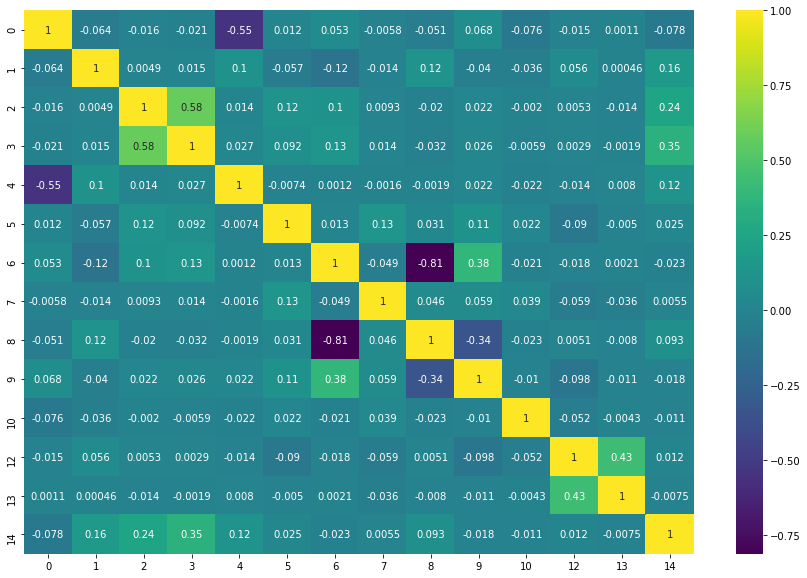

In [9]:
import seaborn as sns
new_df = new_df.drop([new_df.columns[11]], axis = 1)
plt.figure(figsize = (15, 10))
corr = new_df.corr()
#print(corr)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

In [10]:
new_df = new_df.to_numpy() 

In [11]:
# new
new_inp_num = 13
x_new = new_df[:, 0:new_inp_num]
y_new = new_df[:, new_inp_num]
X_train_new, X_val_new, Y_train_new, Y_val_new = train_test_split(x_new, y_new, test_size=0.2, stratify=y_new, random_state=seed)

Epoch 1/2000
53321/53321 [==============================] - 34s 635us/step - loss: 0.0947 - acc: 0.8897 - val_loss: 0.0893 - val_acc: 0.8899
Epoch 2/2000
53321/53321 [==============================] - 34s 642us/step - loss: 0.0862 - acc: 0.8899 - val_loss: 0.0840 - val_acc: 0.8899
Epoch 3/2000
53321/53321 [==============================] - 33s 619us/step - loss: 0.0830 - acc: 0.8899 - val_loss: 0.0822 - val_acc: 0.8898
Epoch 4/2000
53321/53321 [==============================] - 34s 635us/step - loss: 0.0817 - acc: 0.8899 - val_loss: 0.0812 - val_acc: 0.8901
Epoch 5/2000
53321/53321 [==============================] - 34s 629us/step - loss: 0.0809 - acc: 0.8901 - val_loss: 0.0805 - val_acc: 0.8903
Epoch 6/2000
53321/53321 [==============================] - 33s 626us/step - loss: 0.0804 - acc: 0.8902 - val_loss: 0.0802 - val_acc: 0.8904
Epoch 7/2000
53321/53321 [==============================] - 33s 622us/step - loss: 0.0801 - acc: 0.8903 - val_loss: 0.0799 - val_acc: 0.8905
Epoch 8/2000


Epoch 59/2000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0789 - acc: 0.8916 - val_loss: 0.0788 - val_acc: 0.8916
Epoch 60/2000
53321/53321 [==============================] - 31s 585us/step - loss: 0.0788 - acc: 0.8916 - val_loss: 0.0788 - val_acc: 0.8917
Epoch 61/2000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0788 - acc: 0.8916 - val_loss: 0.0788 - val_acc: 0.8917
Epoch 62/2000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0788 - acc: 0.8916 - val_loss: 0.0788 - val_acc: 0.8919
Epoch 63/2000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0788 - acc: 0.8916 - val_loss: 0.0788 - val_acc: 0.8918
Epoch 64/2000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0788 - acc: 0.8916 - val_loss: 0.0788 - val_acc: 0.8918
Epoch 65/2000
53321/53321 [==============================] - 31s 585us/step - loss: 0.0788 - acc: 0.8916 - val_loss: 0.0787 - val_acc: 0.8918
Epoch 

53321/53321 [==============================] - 32s 593us/step - loss: 0.0783 - acc: 0.8918 - val_loss: 0.0783 - val_acc: 0.8919
Epoch 117/2000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0783 - acc: 0.8918 - val_loss: 0.0783 - val_acc: 0.8920
Epoch 118/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0783 - acc: 0.8918 - val_loss: 0.0783 - val_acc: 0.8920
Epoch 119/2000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0783 - acc: 0.8918 - val_loss: 0.0783 - val_acc: 0.8920
Epoch 120/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0783 - acc: 0.8918 - val_loss: 0.0782 - val_acc: 0.8920
Epoch 121/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0783 - acc: 0.8918 - val_loss: 0.0782 - val_acc: 0.8920
Epoch 122/2000
53321/53321 [==============================] - 33s 614us/step - loss: 0.0783 - acc: 0.8918 - val_loss: 0.0782 - val_acc: 0.8920
Epoch 123/2000

53321/53321 [==============================] - 32s 594us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8921
Epoch 174/2000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8921
Epoch 175/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 176/2000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 177/2000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 178/2000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 179/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 180/2000

53321/53321 [==============================] - 32s 591us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 231/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 232/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 233/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 234/2000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 235/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8923
Epoch 236/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 237/2000

53321/53321 [==============================] - 31s 591us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 288/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 289/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 290/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 291/2000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 292/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 293/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 294/2000

53321/53321 [==============================] - 31s 588us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 345/2000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 346/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 347/2000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 348/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 349/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 350/2000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 351/2000

53321/53321 [==============================] - 32s 596us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 402/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 403/2000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 404/2000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 405/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 406/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 407/2000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8926
Epoch 408/2000

53321/53321 [==============================] - 31s 589us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8924
Epoch 459/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8924
Epoch 460/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 461/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 462/2000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 463/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8924
Epoch 464/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 465/2000

53321/53321 [==============================] - 32s 598us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8924
Epoch 516/2000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 517/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 518/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 519/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 520/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 521/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 522/2000

53321/53321 [==============================] - 31s 589us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 573/2000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 574/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 575/2000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 576/2000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 577/2000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8924
Epoch 578/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0776 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 579/2000

53321/53321 [==============================] - 31s 586us/step - loss: 0.0776 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 630/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8924
Epoch 631/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 632/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 633/2000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 634/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0776 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8924
Epoch 635/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8923
Epoch 636/2000

53321/53321 [==============================] - 32s 591us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8925ss: 0.0776 - acc: - ETA: 0s - loss: 0
Epoch 687/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 688/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 689/2000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 690/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 691/2000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0776 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 692/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0776 - acc: 0.8923 - val_loss: 0.

53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 743/2000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0776 - val_acc: 0.8924
Epoch 744/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 745/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 746/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 747/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 748/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 749/2000

53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 800/2000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 801/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 802/2000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 803/2000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 804/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 805/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 806/2000

53321/53321 [==============================] - 32s 595us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 857/2000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8925
Epoch 858/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 859/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 860/2000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0774 - val_acc: 0.8925
Epoch 861/2000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 862/2000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0774 - val_acc: 0.8925
Epoch 863/2000

53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8925
Epoch 914/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 915/2000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 916/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8925
Epoch 917/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0775 - acc: 0.8923 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 918/2000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 919/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 920/2000

53321/53321 [==============================] - 31s 584us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 971/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 972/2000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8925
Epoch 973/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 974/2000
53321/53321 [==============================] - 31s 584us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 975/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 976/2000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0775 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 977/2000

53321/53321 [==============================] - 31s 585us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1028/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1029/2000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1030/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1031/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1032/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1033/2000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 10

53321/53321 [==============================] - 31s 582us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1085/2000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1086/2000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1087/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1088/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1089/2000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8925
Epoch 1090/2000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 10

53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1142/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1143/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1144/2000
53321/53321 [==============================] - 33s 628us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1145/2000
53321/53321 [==============================] - 36s 676us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1146/2000
53321/53321 [==============================] - 37s 687us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1147/2000
53321/53321 [==============================] - 33s 627us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 11

53321/53321 [==============================] - 31s 587us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1199/2000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1200/2000
53321/53321 [==============================] - 31s 591us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1201/2000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1202/2000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1203/2000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1204/2000
53321/53321 [==============================] - 31s 585us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 12

53321/53321 [==============================] - 32s 591us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1256/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1257/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1258/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1259/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1260/2000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1261/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 12

53321/53321 [==============================] - 39s 726us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1313/2000
53321/53321 [==============================] - 33s 623us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1314/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1315/2000
53321/53321 [==============================] - 33s 614us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1316/2000
53321/53321 [==============================] - 32s 605us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1317/2000
53321/53321 [==============================] - 33s 611us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1318/2000
53321/53321 [==============================] - 32s 606us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 13

53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1370/2000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1371/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1372/2000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1373/2000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1374/2000
53321/53321 [==============================] - 31s 591us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1375/2000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8925
Epoch 13

53321/53321 [==============================] - 32s 603us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1427/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1428/2000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1429/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1430/2000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1431/2000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1432/2000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 14

53321/53321 [==============================] - 33s 622us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1484/2000
53321/53321 [==============================] - 33s 613us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1485/2000
53321/53321 [==============================] - 33s 628us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1486/2000
53321/53321 [==============================] - 33s 612us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1487/2000
53321/53321 [==============================] - 33s 617us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1488/2000
53321/53321 [==============================] - 33s 613us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1489/2000
53321/53321 [==============================] - 33s 610us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 14

53321/53321 [==============================] - 33s 616us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1541/2000
53321/53321 [==============================] - 33s 623us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1542/2000
53321/53321 [==============================] - 33s 628us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1543/2000
53321/53321 [==============================] - 35s 650us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1544/2000
53321/53321 [==============================] - 33s 621us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1545/2000
53321/53321 [==============================] - 33s 617us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1546/2000
53321/53321 [==============================] - 33s 614us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 15

53321/53321 [==============================] - 39s 734us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1598/2000
53321/53321 [==============================] - 38s 713us/step - loss: 0.0774 - acc: 0.8924 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1599/2000
53321/53321 [==============================] - 36s 682us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1600/2000
53321/53321 [==============================] - 33s 622us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1601/2000
53321/53321 [==============================] - 33s 617us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1602/2000
53321/53321 [==============================] - 33s 627us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1603/2000
53321/53321 [==============================] - 35s 654us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 16

53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1655/2000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1656/2000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1657/2000
53321/53321 [==============================] - 37s 696us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1658/2000
53321/53321 [==============================] - 36s 679us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1659/2000
53321/53321 [==============================] - 33s 627us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1660/2000
53321/53321 [==============================] - 33s 615us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 16

53321/53321 [==============================] - 33s 615us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1712/2000
53321/53321 [==============================] - 40s 741us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1713/2000
53321/53321 [==============================] - 34s 628us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1714/2000
53321/53321 [==============================] - 33s 612us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1715/2000
53321/53321 [==============================] - 33s 620us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1716/2000
53321/53321 [==============================] - 33s 618us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1717/2000
53321/53321 [==============================] - 32s 604us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 17

53321/53321 [==============================] - 33s 622us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1769/2000
53321/53321 [==============================] - 32s 604us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1770/2000
53321/53321 [==============================] - 32s 609us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1771/2000
53321/53321 [==============================] - 32s 607us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1772/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1773/2000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1774/2000
53321/53321 [==============================] - 33s 621us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 17

53321/53321 [==============================] - 33s 613us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1826/2000
53321/53321 [==============================] - 33s 613us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1827/2000
53321/53321 [==============================] - 33s 612us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1828/2000
53321/53321 [==============================] - 33s 610us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1829/2000
53321/53321 [==============================] - 33s 616us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1830/2000
53321/53321 [==============================] - 32s 609us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1831/2000
53321/53321 [==============================] - 33s 610us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 18

53321/53321 [==============================] - 32s 601us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1883/2000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1884/2000
53321/53321 [==============================] - 33s 611us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1885/2000
53321/53321 [==============================] - 32s 602us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1886/2000
53321/53321 [==============================] - 33s 610us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1887/2000
53321/53321 [==============================] - 32s 603us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1888/2000
53321/53321 [==============================] - 33s 617us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 18

53321/53321 [==============================] - 31s 591us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1940/2000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1941/2000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1942/2000
53321/53321 [==============================] - 33s 610us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1943/2000
53321/53321 [==============================] - 32s 608us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1944/2000
53321/53321 [==============================] - 32s 607us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1945/2000
53321/53321 [==============================] - 33s 610us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 19

53321/53321 [==============================] - 33s 611us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1997/2000
53321/53321 [==============================] - 33s 616us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1998/2000
53321/53321 [==============================] - 32s 609us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1999/2000
53321/53321 [==============================] - 33s 623us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 2000/2000
53321/53321 [==============================] - 33s 613us/step - loss: 0.0773 - acc: 0.8925 - val_loss: 0.0773 - val_acc: 0.8927
time : 64322.847351789474


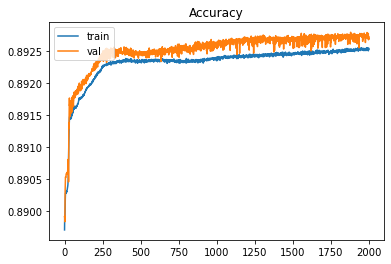

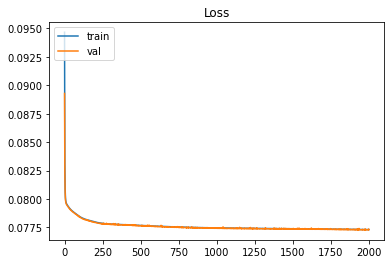

In [12]:
# MLP: 12x30x1 - 2000 epochs
num_epochs = 2000

start = time.time()  # 시작 시간 저장
with tf.device("/cpu:0"):
    model = Sequential()
    model.add(Dense(30, input_dim=new_inp_num, activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])
    history = model.fit(X_train_new, Y_train_new, validation_data=(X_val_new, Y_val_new), epochs=num_epochs, batch_size=num_batch)
    model.save('Original_model_mlp_2000.h5')
    print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
#모델 평가
model = load_model('Original_model_mlp_2000.h5')
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(Y_test, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(Y_test, y_pred, target_names=target_names))

model_predictions = model.predict_classes(X_test, batch_size=200, verbose=0)
print(model_predictions)

print(confusion_matrix(Y_test, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(Y_test, y_pred, target_names=target_names))

print(confusion_matrix(Y_test, model_predictions))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(Y_test,model_predictions, target_names=target_names))

Epoch 1/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0939 - acc: 0.8899 - val_loss: 0.0894 - val_acc: 0.8899
Epoch 2/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0864 - acc: 0.8899 - val_loss: 0.0842 - val_acc: 0.8899
Epoch 3/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0832 - acc: 0.8899 - val_loss: 0.0824 - val_acc: 0.8898
Epoch 4/3000
53321/53321 [==============================] - 31s 574us/step - loss: 0.0818 - acc: 0.8900 - val_loss: 0.0813 - val_acc: 0.8902
Epoch 5/3000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0810 - acc: 0.8901 - val_loss: 0.0806 - val_acc: 0.8904
Epoch 6/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0804 - acc: 0.8902 - val_loss: 0.0802 - val_acc: 0.8905
Epoch 7/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0801 - acc: 0.8902 - val_loss: 0.0799 - val_acc: 0.8905
Epoch 8/3000


Epoch 59/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0790 - acc: 0.8915 - val_loss: 0.0790 - val_acc: 0.8917
Epoch 60/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0790 - acc: 0.8916 - val_loss: 0.0790 - val_acc: 0.8917
Epoch 61/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0790 - acc: 0.8916 - val_loss: 0.0789 - val_acc: 0.8917
Epoch 62/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0790 - acc: 0.8916 - val_loss: 0.0789 - val_acc: 0.8919
Epoch 63/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0790 - acc: 0.8916 - val_loss: 0.0789 - val_acc: 0.8919
Epoch 64/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0790 - acc: 0.8916 - val_loss: 0.0789 - val_acc: 0.8917
Epoch 65/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0789 - acc: 0.8916 - val_loss: 0.0789 - val_acc: 0.8918
Epoch 

53321/53321 [==============================] - 32s 596us/step - loss: 0.0784 - acc: 0.8917 - val_loss: 0.0784 - val_acc: 0.8919
Epoch 117/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0784 - acc: 0.8917 - val_loss: 0.0784 - val_acc: 0.8920
Epoch 118/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0784 - acc: 0.8918 - val_loss: 0.0784 - val_acc: 0.8920
Epoch 119/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0784 - acc: 0.8918 - val_loss: 0.0784 - val_acc: 0.8920
Epoch 120/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0784 - acc: 0.8918 - val_loss: 0.0784 - val_acc: 0.8920
Epoch 121/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0784 - acc: 0.8918 - val_loss: 0.0784 - val_acc: 0.8919
Epoch 122/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0784 - acc: 0.8918 - val_loss: 0.0783 - val_acc: 0.8920
Epoch 123/3000

53321/53321 [==============================] - 38s 716us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 174/3000
53321/53321 [==============================] - 32s 603us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 175/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 176/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 177/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 178/3000
53321/53321 [==============================] - 32s 606us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 179/3000
53321/53321 [==============================] - 32s 602us/step - loss: 0.0781 - acc: 0.8920 - val_loss: 0.0780 - val_acc: 0.8922
Epoch 180/3000

53321/53321 [==============================] - 32s 596us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 231/3000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 232/3000
53321/53321 [==============================] - 31s 591us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8924
Epoch 233/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 234/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8923
Epoch 235/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8923
Epoch 236/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0779 - acc: 0.8922 - val_loss: 0.0779 - val_acc: 0.8923
Epoch 237/3000

53321/53321 [==============================] - 32s 595us/step - loss: 0.0778 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8923
Epoch 288/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0778 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 289/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0778 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 290/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0778 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 291/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0778 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 292/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0778 - acc: 0.8922 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 293/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 294/3000

53321/53321 [==============================] - 31s 582us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8924
Epoch 345/3000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 346/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8924
Epoch 347/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8923
Epoch 348/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 349/3000
53321/53321 [==============================] - 31s 591us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 350/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0778 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8925
Epoch 351/3000

53321/53321 [==============================] - 32s 595us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 402/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 403/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 404/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 405/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0778 - val_acc: 0.8924
Epoch 406/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8924
Epoch 407/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 408/3000

53321/53321 [==============================] - 32s 600us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8924
Epoch 459/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8924
Epoch 460/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 461/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 462/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 463/3000
53321/53321 [==============================] - 31s 584us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 464/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0777 - acc: 0.8923 - val_loss: 0.0777 - val_acc: 0.8925
Epoch 465/3000

53321/53321 [==============================] - 31s 578us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0777 - val_acc: 0.8924
Epoch 516/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 517/3000
53321/53321 [==============================] - 31s 579us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 518/3000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 519/3000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 520/3000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 521/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0777 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 522/3000

53321/53321 [==============================] - 32s 595us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 573/3000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 574/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 575/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 576/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 577/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8925
Epoch 578/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 579/3000

53321/53321 [==============================] - 32s 597us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 630/3000
53321/53321 [==============================] - 31s 583us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 631/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 632/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 633/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0776 - acc: 0.8924 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 634/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 635/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0777 - val_acc: 0.8924
Epoch 636/3000

53321/53321 [==============================] - 32s 593us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 687/3000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 688/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 689/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 690/3000
53321/53321 [==============================] - 32s 605us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 691/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 692/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 693/3000

53321/53321 [==============================] - 32s 592us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 744/3000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0776 - val_acc: 0.8926
Epoch 745/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 746/3000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 747/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 748/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 749/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0776 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 750/3000

53321/53321 [==============================] - 32s 596us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 801/3000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 802/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 803/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 804/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 805/3000
53321/53321 [==============================] - 32s 602us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 806/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 807/3000

53321/53321 [==============================] - 32s 595us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 858/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 859/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 860/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 861/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 862/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 863/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 864/3000

53321/53321 [==============================] - 31s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 915/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 916/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 917/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 918/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 919/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 920/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 921/3000

53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 972/3000
53321/53321 [==============================] - 32s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 973/3000
53321/53321 [==============================] - 31s 591us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 974/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 975/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 976/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 977/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 978/3000

53321/53321 [==============================] - 31s 584us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1029/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1030/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1031/3000
53321/53321 [==============================] - 31s 578us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1032/3000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1033/3000
53321/53321 [==============================] - 31s 573us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0775 - val_acc: 0.8927
Epoch 1034/3000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 10

53321/53321 [==============================] - 31s 586us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1086/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1087/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1088/3000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1089/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0775 - val_acc: 0.8926
Epoch 1090/3000
53321/53321 [==============================] - 33s 615us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1091/3000
53321/53321 [==============================] - 32s 605us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 10

53321/53321 [==============================] - 32s 605us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1143/3000
53321/53321 [==============================] - 32s 603us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1144/3000
53321/53321 [==============================] - 33s 610us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1145/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1146/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0775 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1147/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1148/3000
53321/53321 [==============================] - 31s 584us/step - loss: 0.0775 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 11

53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1200/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1201/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1202/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1203/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1204/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1205/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 12

53321/53321 [==============================] - 32s 598us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1257/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1258/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1259/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1260/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1261/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8925 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1262/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 12

53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1314/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1315/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1316/3000
53321/53321 [==============================] - 31s 584us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1317/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1318/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1319/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 13

53321/53321 [==============================] - 31s 590us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1371/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1372/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1373/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1374/3000
53321/53321 [==============================] - 34s 644us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1375/3000
53321/53321 [==============================] - 36s 679us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1376/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 13

53321/53321 [==============================] - 32s 592us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1428/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1429/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1430/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1431/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1432/3000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1433/3000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 14

53321/53321 [==============================] - 31s 582us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1485/3000
53321/53321 [==============================] - 31s 585us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1486/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1487/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1488/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1489/3000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1490/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 14

53321/53321 [==============================] - 31s 591us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1542/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1543/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1544/3000
53321/53321 [==============================] - 31s 583us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1545/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1546/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1547/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 15

53321/53321 [==============================] - 32s 600us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1599/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1600/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1601/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1602/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1603/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1604/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 16

53321/53321 [==============================] - 32s 599us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1656/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1657/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1658/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1659/3000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1660/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1661/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 16

53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1713/3000
53321/53321 [==============================] - 31s 591us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1714/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8926
Epoch 1715/3000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1716/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1717/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1718/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 17

53321/53321 [==============================] - 32s 591us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8927
Epoch 1770/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1771/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1772/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1773/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1774/3000
53321/53321 [==============================] - 32s 596us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1775/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 17

53321/53321 [==============================] - 31s 588us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1827/3000
53321/53321 [==============================] - 32s 600us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1828/3000
53321/53321 [==============================] - 31s 584us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1829/3000
53321/53321 [==============================] - 31s 577us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1830/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1831/3000
53321/53321 [==============================] - 31s 583us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1832/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 18

53321/53321 [==============================] - 31s 584us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1884/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1885/3000
53321/53321 [==============================] - 31s 580us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1886/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1887/3000
53321/53321 [==============================] - 31s 585us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1888/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1889/3000
53321/53321 [==============================] - 34s 634us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 18

53321/53321 [==============================] - 31s 579us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1941/3000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1942/3000
53321/53321 [==============================] - 31s 576us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1943/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1944/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1945/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 1946/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0774 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 19

53321/53321 [==============================] - 32s 600us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8927
Epoch 1998/3000
53321/53321 [==============================] - 34s 634us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0774 - val_acc: 0.8928
Epoch 1999/3000
53321/53321 [==============================] - 33s 624us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2000/3000
53321/53321 [==============================] - 32s 606us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2001/3000
53321/53321 [==============================] - 32s 601us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2002/3000
53321/53321 [==============================] - 32s 607us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2003/3000
53321/53321 [==============================] - 32s 608us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 20

53321/53321 [==============================] - 31s 580us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2055/3000
53321/53321 [==============================] - 31s 588us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2056/3000
53321/53321 [==============================] - 31s 584us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2057/3000
53321/53321 [==============================] - 31s 581us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2058/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2059/3000
53321/53321 [==============================] - 33s 622us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2060/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 20

53321/53321 [==============================] - 32s 600us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2112/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2113/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2114/3000
53321/53321 [==============================] - 31s 590us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2115/3000
53321/53321 [==============================] - 33s 610us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2116/3000
53321/53321 [==============================] - 32s 593us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2117/3000
53321/53321 [==============================] - 31s 589us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 21

53321/53321 [==============================] - 32s 598us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2169/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2170/3000
53321/53321 [==============================] - 32s 592us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2171/3000
53321/53321 [==============================] - 32s 598us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2172/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2173/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2174/3000
53321/53321 [==============================] - 31s 587us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 21

53321/53321 [==============================] - 31s 580us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2226/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2227/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2228/3000
53321/53321 [==============================] - 33s 616us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2229/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2230/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2231/3000
53321/53321 [==============================] - 32s 604us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 22

53321/53321 [==============================] - 31s 583us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2283/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2284/3000
53321/53321 [==============================] - 32s 594us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2285/3000
53321/53321 [==============================] - 32s 605us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2286/3000
53321/53321 [==============================] - 31s 582us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2287/3000
53321/53321 [==============================] - 32s 606us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2288/3000
53321/53321 [==============================] - 40s 742us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 22

53321/53321 [==============================] - 32s 594us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2340/3000
53321/53321 [==============================] - 33s 610us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2341/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2342/3000
53321/53321 [==============================] - 32s 595us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2343/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2344/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2345/3000
53321/53321 [==============================] - 32s 597us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 23

53321/53321 [==============================] - 39s 725us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2397/3000
53321/53321 [==============================] - 36s 680us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2398/3000
53321/53321 [==============================] - 37s 696us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2399/3000
53321/53321 [==============================] - 37s 687us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2400/3000
53321/53321 [==============================] - 36s 678us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2401/3000
53321/53321 [==============================] - 37s 693us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2402/3000
53321/53321 [==============================] - 35s 655us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 24

53321/53321 [==============================] - 31s 584us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2454/3000
53321/53321 [==============================] - 29s 552us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2455/3000
53321/53321 [==============================] - 29s 541us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2456/3000
53321/53321 [==============================] - 30s 570us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2457/3000
53321/53321 [==============================] - 29s 539us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2458/3000
53321/53321 [==============================] - 30s 554us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2459/3000
53321/53321 [==============================] - 30s 553us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 24

53321/53321 [==============================] - 29s 540us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8929
Epoch 2511/3000
53321/53321 [==============================] - 30s 558us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2512/3000
53321/53321 [==============================] - 28s 532us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8929
Epoch 2513/3000
53321/53321 [==============================] - 30s 556us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2514/3000
53321/53321 [==============================] - 31s 575us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2515/3000
53321/53321 [==============================] - 28s 532us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2516/3000
53321/53321 [==============================] - 28s 527us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 25

Epoch 2567/3000
53321/53321 [==============================] - 30s 558us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2568/3000
53321/53321 [==============================] - 29s 545us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0773 - val_acc: 0.8929
Epoch 2569/3000
53321/53321 [==============================] - 32s 599us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2570/3000
53321/53321 [==============================] - 29s 539us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2571/3000
53321/53321 [==============================] - 30s 565us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2572/3000
53321/53321 [==============================] - 31s 586us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2573/3000
53321/53321 [==============================] - 30s 562us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc:

Epoch 2624/3000
53321/53321 [==============================] - 28s 520us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2625/3000
53321/53321 [==============================] - 28s 519us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2626/3000
53321/53321 [==============================] - 28s 521us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2627/3000
53321/53321 [==============================] - 28s 525us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2628/3000
53321/53321 [==============================] - 28s 522us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2629/3000
53321/53321 [==============================] - 28s 518us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2630/3000
53321/53321 [==============================] - 28s 519us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc:

53321/53321 [==============================] - 24s 450us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2681/3000
53321/53321 [==============================] - 24s 453us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2682/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2683/3000
53321/53321 [==============================] - 24s 452us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2684/3000
53321/53321 [==============================] - 24s 453us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2685/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2686/3000
53321/53321 [==============================] - 24s 458us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 26

53321/53321 [==============================] - 24s 453us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2738/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2739/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2740/3000
53321/53321 [==============================] - 24s 455us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2741/3000
53321/53321 [==============================] - 24s 453us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8929
Epoch 2742/3000
53321/53321 [==============================] - 24s 452us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2743/3000
53321/53321 [==============================] - 24s 450us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 27

53321/53321 [==============================] - 24s 454us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2795/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2796/3000
53321/53321 [==============================] - 24s 452us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2797/3000
53321/53321 [==============================] - 25s 462us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2798/3000
53321/53321 [==============================] - 25s 467us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2799/3000
53321/53321 [==============================] - 24s 459us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2800/3000
53321/53321 [==============================] - 24s 456us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 28

53321/53321 [==============================] - 24s 452us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8929
Epoch 2852/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8929
Epoch 2853/3000
53321/53321 [==============================] - 24s 453us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0773 - val_acc: 0.8928
Epoch 2854/3000
53321/53321 [==============================] - 24s 453us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2855/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2856/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2857/3000
53321/53321 [==============================] - 24s 457us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8929
Epoch 28

53321/53321 [==============================] - 24s 455us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8929
Epoch 2909/3000
53321/53321 [==============================] - 25s 461us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2910/3000
53321/53321 [==============================] - 24s 454us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2911/3000
53321/53321 [==============================] - 24s 456us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2912/3000
53321/53321 [==============================] - 24s 455us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2913/3000
53321/53321 [==============================] - 24s 456us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2914/3000
53321/53321 [==============================] - 24s 455us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 29

53321/53321 [==============================] - 22s 405us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2966/3000
53321/53321 [==============================] - 21s 403us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2967/3000
53321/53321 [==============================] - 22s 404us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2968/3000
53321/53321 [==============================] - 22s 404us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2969/3000
53321/53321 [==============================] - 21s 401us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2970/3000
53321/53321 [==============================] - 22s 403us/step - loss: 0.0773 - acc: 0.8927 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 2971/3000
53321/53321 [==============================] - 21s 402us/step - loss: 0.0773 - acc: 0.8926 - val_loss: 0.0772 - val_acc: 0.8928
Epoch 29

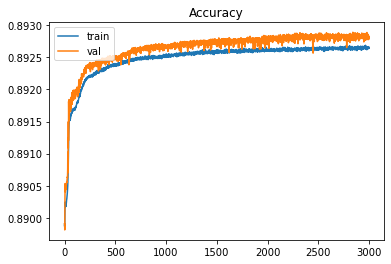

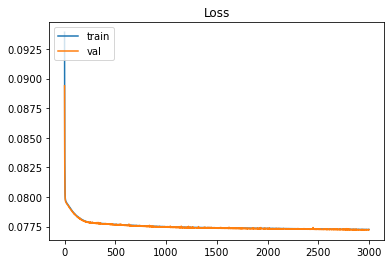

In [13]:
# MLP: 12x30x1 - 3000 epochs
num_epochs = 3000

start = time.time()  # 시작 시간 저장
with tf.device("/cpu:0"):
    model = Sequential()
    model.add(Dense(30, input_dim=new_inp_num, activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])
    history = model.fit(X_train_new, Y_train_new, validation_data=(X_val_new, Y_val_new), epochs=num_epochs, batch_size=num_batch)
    model.save('Original_model_mlp_3000.h5')
    print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
#모델 평가
model = load_model('Original_model_mlp_3000.h5')
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(Y_test, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(Y_test, y_pred, target_names=target_names))
del model